In [1]:
from utils.split import RandomSplitPt
from utils.dataset import ReHemorrhageDataset
from utils.model import HemoResNet50, HemoResNet18
from utils.metric import hemorrhage_metrics
from utils.util import get_test_pt_id_list, prediction_to_csv
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch
from torchvision import transforms
import numpy as np
import pandas as pd

In [2]:
test_id_list = get_test_pt_id_list("Blood_data/test/")
val_transform = transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                                        std=[0.5, 0.5, 0.5])
                                ])
test_dataset = ReHemorrhageDataset(test_id_list, data_root = "./Blood_data/test/", stack_img = True, mode="test",augmentation=val_transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True, num_workers = 16, pin_memory=True)

In [3]:
device = "cuda"
num_class = 5

model = HemoResNet18(in_channels = 3, n_classes=num_class)
model.load_state_dict(torch.load("./model/resnet18_RGB_sgdnesterov_weight_LLRaug_64.pth"))
model.to(device)

HemoResNet18(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

In [5]:
model.eval()
pt_name_list = []
image_name_list = []
prediction = []
with torch.no_grad():
    for i, (pt_name, img_name, data) in enumerate(test_loader, 1):
        print(f"Process {i} / {len(test_loader)}    ", end="\r")
        data = data.to(device)

        logits = model(data)
        logits = torch.sigmoid(logits)
        logits = logits.cpu().numpy()
        prediction.append(logits)
        pt_name_list += list(pt_name)
        image_name_list += list(img_name)
prediction = np.concatenate((prediction))

In [7]:
prediction_to_csv(pt_name_list, image_name_list, prediction, 
                  output_csv_name="./resnet18_RGB_sgdnesterov_weight_LLRaug_64_0.5.csv", 
                  threshold=0.5, to_kaggle=True, remove_defunct=True)

Save as ./resnet18_RGB_sgdnesterov_weight_LLRaug_64_0.5_KAGGLE.csv


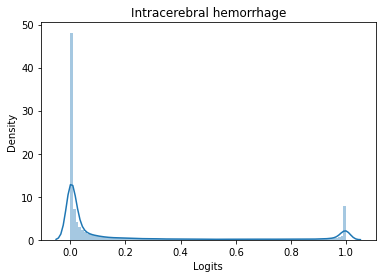

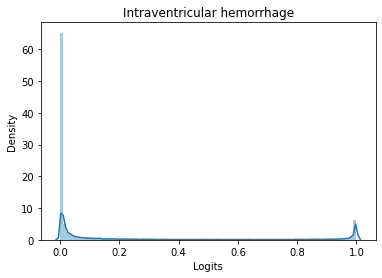

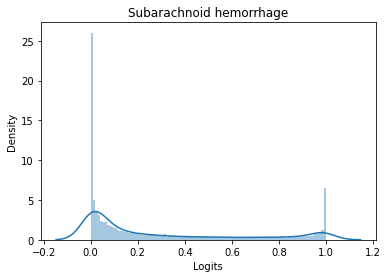

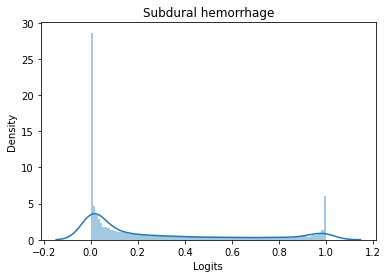

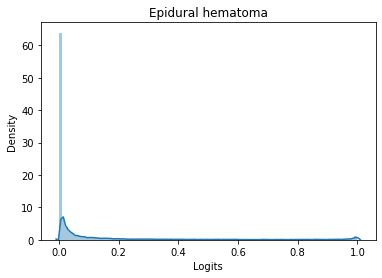

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
category = ['Intracerebral hemorrhage', 'Intraventricular hemorrhage', 'Subarachnoid hemorrhage', 'Subdural hemorrhage', 'Epidural hematoma']
for i in range(5):
    sns.distplot(prediction[:,i], bins=100)
    plt.title(f"{category[i]}")
    plt.xlabel("Logits")
    plt.ylabel("Density")
    plt.show()